In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from model_spec import model_spec
from pol_model import load_bands, model_p, get_a_b
from draine_dust_2D import draine_dust
from scipy.optimize import minimize, LinearConstraint

In [2]:
#The measured values in each band. 
p_measured = np.array([0.0973, 0.1085, 0.1466])
p_unc = np.array([0.0037, 0.0023, 0.0041])

In [3]:
def pol_plot(p_measured, p_unc, mod_p, spec):
    wave = np.array([5500., 6500., 8000.]) / spec.zspec
    plt.errorbar(wave, p_measured, yerr=p_unc, fmt='o', label='Measurements')
    plt.plot(wave, mod_p, 'ks', label='Dust SMC')
    plt.legend()
    plt.xlabel('Wavelength (Angstroms)')
    plt.ylabel('Polarization fraction')
    plt.show()

## Model the SDSS Spectrum

In [4]:
spec, model = model_spec()

## Model the Broad-band polarizations

In [5]:
bands = load_bands()

In [6]:
def chi2(x, dust, spec):
    phi = x[3]
    theta = dust.pfrac(spec.lam_rest.to(u.um).value, phi).flatten()
    a, b = get_a_b(theta, theta, bands, spec, model)
    p_mod = np.zeros(3)
    for j in range(3):
        p_mod[j] = model_p(x[:3], a[j], b[j])
    return np.sum(((p_measured-p_mod)/p_unc)**2)

In [7]:
dust_types = ["SMC", "LMC", "MW"]
mod_p = np.zeros((len(dust_types),len(bands)))
for k, dust_type in enumerate(dust_types):

    dust = draine_dust(type=dust_type)
    #The code has difficulties converging above and below 90 deg. So let's try both and save the best.
    for i in range(2):
        x0 = np.array([0.9, 0.1, 70., 60.])
        if i==1:
            x0[-1] = 150.
        G = np.identity(x0.shape[0])
        min_vals = [0., 0., 0., 0.]
        max_vals = [1., 1., 360., 180.]
        lincon = LinearConstraint(G, min_vals, max_vals)
        xopt_aux = minimize(chi2, x0=x0, constraints=lincon, args=(dust, spec))
        if i==0 or xopt_aux.fun < xopt.fun:
            xopt = xopt_aux
    print(xopt)

    phi = xopt.x[3]
    theta = dust.pfrac(spec.lam_rest.to(u.um).value, phi).flatten()
    a, b = get_a_b(theta, theta, bands, spec, model)

    for j in range(len(bands)):
        mod_p[k,j] = model_p(xopt.x[:3], a[j], b[j])
        print(mod_p[k,j])

    #pol_plot(p_measured, p_unc, mod_p, spec)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 33.16486654273035
       x: [ 9.625e-01  1.000e+00  8.220e+01  8.203e+01]
     nit: 15
     jac: [-3.349e-02 -7.549e+01  4.778e-04 -1.869e-04]
    nfev: 79
    njev: 15
0.08908666636151122
0.11548819704527652
0.1287258260798382
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 12.413731613768567
       x: [ 1.000e+00  3.982e-01  9.000e+01  1.277e+02]
     nit: 26
     jac: [-7.878e+01 -6.389e-03 -9.298e-06 -2.856e-04]
    nfev: 140
    njev: 26
0.10736830156516874
0.10354643092070334
0.14410447894537465
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 22.32672396051136
       x: [ 1.000e+00  1.000e+00  7.952e+01  7.671e+01]
     nit: 14
     jac: [-9.082e+01 -3.884e+01  2.747e-04 -4.578e-05]
    nfev: 74
    njev: 14
0.09121524893187144
0.11320770893795903
0.1304933437662589


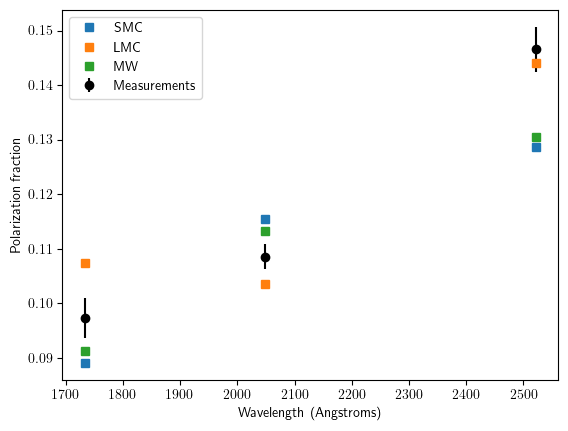

In [8]:
wave = np.array([5500., 6500., 8000.]) / spec.zspec

fig, ax = plt.subplots(1)

ax.errorbar(wave, p_measured, yerr=p_unc, fmt='ko', label='Measurements')
for k, dust_type in enumerate(dust_types):
    ax.plot(wave, mod_p[k], 's', label=dust_type)
ax.legend()
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Polarization fraction')
plt.show()

### Dust for continuum and Gas for Broad Lines.

In [9]:
def chi2(x, dust, spec):
    phi = x[3]
    theta_A = dust.pfrac(spec.lam_rest.to(u.um).value, phi).flatten()
    theta_B = np.ones(len(spec.lam_rest))
    a, b = get_a_b(theta_A, theta_B, bands, spec, model)
    p_mod = np.zeros(3)
    for j in range(3):
        p_mod[j] = model_p(x[:3], a[j], b[j])
    return np.sum(((p_measured-p_mod)/p_unc)**2)

In [10]:
dust_types = ["SMC", "LMC", "MW"]
mod_p = np.zeros((len(dust_types),len(bands)))
for k, dust_type in enumerate(dust_types):

    dust = draine_dust(type=dust_type)

    #The code has difficulties converging above and below 90 deg. So let's try both and save the best.
    for i in range(2):
        x0 = np.array([0.9, 0.3, 70., 60.])
        if i==1:
            x0[-1] = 150.
        G = np.identity(x0.shape[0])
        min_vals = [0., 0., 0., 0.]
        max_vals = [1., 1., 360., 180.]
        lincon = LinearConstraint(G, min_vals, max_vals)
        xopt_aux = minimize(chi2, x0=x0, constraints=lincon, args=(dust, spec))
        if i==0 or xopt_aux.fun < xopt.fun:
            xopt = xopt_aux
    print(xopt)

    phi = xopt.x[3]
    theta_A = dust.pfrac(spec.lam_rest.to(u.um).value, phi).flatten()
    theta_B = np.ones(len(spec.lam_rest))
    a, b = get_a_b(theta_A, theta_B, bands, spec, model)

    for j in range(len(bands)):
        mod_p[k,j] = model_p(xopt.x[:3], a[j], b[j])
        print(mod_p[k,j])

    #pol_plot(p_measured, p_unc, mod_p, spec)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 25.089790386321095
       x: [ 1.000e+00  4.804e-01  9.000e+01  9.077e+01]
     nit: 37
     jac: [-1.681e+02 -4.292e-02 -5.484e-06  1.783e-04]
    nfev: 194
    njev: 37
0.11050063334560009
0.10329612311423769
0.13556660003234008
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.993868753357584
       x: [ 1.000e+00  1.386e-01  8.285e-03  1.481e+02]
     nit: 42
     jac: [-1.111e+01 -2.697e-02  6.527e-06  1.685e-03]
    nfev: 221
    njev: 42
0.10038304747432693
0.10725544275809147
0.14626312467296954
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 26.59660996679009
       x: [ 1.000e+00  3.341e-01  8.999e+01  7.838e+01]
     nit: 44
     jac: [-2.332e+02  6.145e-02 -5.150e-05 -2.923e-04]
    nfev: 233
    njev: 44
0.10843787395827141
0.10418584932057949
0.13125001881181417


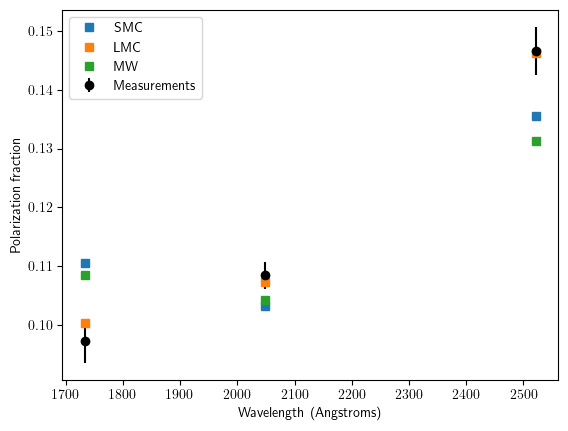

In [11]:
wave = np.array([5500., 6500., 8000.]) / spec.zspec

fig, ax = plt.subplots(1)

ax.errorbar(wave, p_measured, yerr=p_unc, fmt='ko', label='Measurements')
for k, dust_type in enumerate(dust_types):
    ax.plot(wave, mod_p[k], 's', label=dust_type)
ax.legend()
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Polarization fraction')
plt.show()